In [431]:
import pyro


import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import json
import pandas as pd
import os
import pyro.distributions as dist
import torch
from sklearn.neighbors import KernelDensity
import scipy
import utils
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from collections import defaultdict
import os
import logging
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam,ClippedAdam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete,Trace_ELBO

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [42]:
adata = sc.read_h5ad("N_ribas310_clones.h5")[0:100]

KeyboardInterrupt: 

In [4]:
infer = pd.read_csv("N_infer_full_10.16.21", index_col=0)

In [141]:
adata_subsampled_orig, infer_subsampled = utils.format_data(adata, infer, 200, 200)

Trying to set attribute `._uns` of view, copying.


In [374]:
num_cells = 1000

In [405]:
adata_subsampled = adata[:1000,:1000]#adata_subsampled_orig [0:num_cells]

In [456]:
adata_tensor=torch.tensor(adata_subsampled.X.astype("int"))

In [457]:
adata_tensor.shape

torch.Size([1000, 1000])

HPF model (starting from non-hierarchial)

In [409]:
def model(data):
    # define the hyperparameters that control the beta prior
    theta0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)
    theta1 = torch.tensor(1.0)
    beta1 = torch.tensor(1.0)
    
    xi0 = torch.tensor(.3)
    eta0 = torch.tensor(1.0)
    std_1 = np.std(np.sum(adata_subsampled.layers['counts'], axis=1))
    xi1 = torch.tensor(float(np.mean(np.sum(adata_subsampled.layers['counts'],
                                           axis=1))/std_1))
    eta1 = torch.tensor(1.0)
    
    C=data.shape[0]
    G=data.shape[1]
    
    # sample f from the beta prior
    with pyro.plate('thetas',C):
        xi = pyro.sample("xi", dist.Gamma(xi0,xi1))
        theta = pyro.sample("theta", dist.Gamma(theta0, xi))
    
    with pyro.plate('betas',G):
        eta = pyro.sample("eta", dist.Gamma(eta0, eta1))
        beta = pyro.sample("beta", dist.Gamma(beta0, eta))
    # loop over the observed data
   # print(np.mean(beta.detach().numpy()))
    with pyro.plate('beta_1',G):
        with pyro.plate('theta_1',C):
        # observe datapoint i using the bernoulli likelihood
        
            pyro.sample("X", dist.Poisson(torch.outer(theta , beta)), obs=data)


In [420]:
def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    theta_sq = pyro.param("theta_sq", torch.tensor(1.0),
                         constraint=dist.constraints.positive)
    theta_lq = pyro.param("theta_lq", torch.tensor(1.0),
                     constraint=dist.constraints.positive)
    
    beta_sq = pyro.param("theta_sq", torch.tensor(1.0),
                         constraint=dist.constraints.positive)
    beta_lq = pyro.param("theta_lq", torch.tensor(1.0),
                     constraint=dist.constraints.positive)
    
    a_q = pyro.param("a_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    
    std_1 = np.std(np.sum(adata_subsampled.layers['counts'], axis=1))
    xi1 = torch.tensor(float(np.mean(np.sum(adata_subsampled.layers['counts'],
                                           axis=1))/std_1))
    ap_q = pyro.param("ap_q",xi1, constraint=dist.constraints.positive)
    
    eta_g0 = pyro.param("eta_0",torch.tensor(1.0), constraint=dist.constraints.positive)
    eta_g1 = pyro.param("eta_1",torch.tensor(1.0), constraint=dist.constraints.positive)
    C=data.shape[0]
    G=data.shape[1]
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    with pyro.plate('thetas',C):
        xi = pyro.sample("xi",dist.Gamma(a_q,ap_q))

        theta = pyro.sample("theta", dist.Gamma(theta_sq, xi))
        
    with pyro.plate('betas',G):
        eta = pyro.sample("eta", dist.Gamma(eta_g0, eta_g1))
        beta = pyro.sample("beta", dist.Gamma(beta_sq, eta))
    
        #print(param_store)
    param_store = pyro.get_param_store()
    param_store.__setitem__('theta',theta)
    param_store.__setitem__('beta',beta)

In [465]:
#clear past iterations
pyro.get_param_store().clear()
# set up the optimizer
n_steps = 20000
initial_lr = 0.005
gamma = 0.01  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / n_steps)
adam_params = {"lr": initial_lr, "betas": (0.99, 0.999),"lrd":lrd}
optimizer = ClippedAdam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
# do gradient steps
for step in range(n_steps):
    #print(step)
    loss=svi.step(adata_tensor)
    losses.append(loss)
    if step % 10 == 0:
        print(loss)
        

205213816.49542236
133120812.6829834
55702804.41520691
45160025.46616173
17415671.06626129
14690345.357063293
7770971.134994507
6131823.355499268
3155009.04838562
1648427.0631637573
1685702.3078193665
779543.9332885742
490657.7471923828
338200.265625
292411.6814880371
185917.13040161133
129844.28279495239
97587.57232666016
88113.50480651855
56410.192569732666
53436.423179626465
47305.757583618164
47875.796966552734
48604.63397216797
55088.38357543945
47337.02978515625
47908.868896484375
52112.76916503906
47467.07177734375
46356.0078125
46152.10137939453
46068.707275390625
50409.63232421875
46346.881591796875
45179.42932128906
46462.32922363281
49971.251892089844
45777.294677734375
51413.840270996094
42405.21176147461
45984.73913574219
47353.40922546387
45697.22055053711
45486.483627319336
46382.830505371094
48661.88604736328
45608.20275878906
45295.42987060547
44553.897369384766
42609.21160888672
45988.964935302734
45155.82244873047
49376.652587890625
41912.02005004883
43854.0728149414

37133.374755859375
38592.56832885742
43454.05924987793
41730.086181640625
38098.98486328125
43407.00178527832
39068.344177246094
38761.62042236328
40256.56788635254
36195.254974365234
39034.43878173828
38251.90072631836
42632.15173339844
40026.677993774414
38966.1477355957
39555.78860473633
40923.27590942383
40517.353927612305
41039.2453918457
42391.64518737793
41664.02749633789
43571.637283325195
39333.88035583496
43431.67123413086
40834.16011047363
45143.62008666992
41451.61274719238
41169.463317871094
43323.45002746582
39675.300231933594
48963.321838378906
42814.989807128906
44678.49572753906
41196.652404785156
39666.25035095215
42068.223556518555
38806.07116699219
45170.05110168457
44592.33676147461
40209.538314819336
41325.255783081055
44895.004135131836
41301.264587402344
40830.663345336914
43543.10577392578
37348.919677734375
41074.41027832031
41674.630630493164
39761.29522705078
43817.11196899414
41082.94071960449
40700.05780029297
39616.79345703125
39097.8376159668
44717.68783

43181.06945800781
39152.57873535156
41088.89433288574
37383.563735961914
41466.895416259766
39224.18469238281
40636.733947753906
40394.2801361084
43195.17205810547
41410.056076049805
38332.08445739746
55368.149322509766
40588.54232788086
39729.06672668457
40653.693618774414
39643.39587402344
48763.76084899902
38453.156341552734
40281.161209106445
44060.83680725098
42603.9714050293
42835.33108520508
45350.761810302734
39375.670654296875
42765.04690551758
41041.586837768555
40907.038635253906
41330.39192199707
41699.43637084961
38367.592681884766
41243.38687133789
38684.50875854492
41041.01223754883
38119.284729003906
44338.17288208008
41811.365478515625
43264.00216674805
38731.08074951172
38365.3616027832
38521.18344116211
39638.78015136719
40133.48272705078
42134.595306396484
43527.58322143555
38676.772033691406
48361.558502197266
41066.05285644531
38190.18258666992
46756.441009521484
41909.823822021484
43882.84587097168
41584.24465942383
42677.234436035156
40664.47506713867
39108.4934

38021.98876953125
40976.404296875
41341.719329833984
40387.66148376465
43300.16131591797
40620.35038757324
39158.68342590332
47747.60369873047
40936.882080078125
39692.28480529785
41929.96969604492
41046.4714050293
44134.56434631348
46494.598556518555
46292.00244140625
40115.318283081055
41274.18801879883
37481.54335021973
42135.43315124512
41756.996826171875
41558.87739562988
38316.92770385742
40126.20115661621
39535.81024169922
42724.755432128906
41559.9016418457
40567.56848144531
37910.61357116699
37830.885192871094
40783.45642089844
39675.153076171875
43951.846252441406
40891.22790527344
43286.898193359375
44117.084701538086
42185.588287353516
43822.111740112305
48097.06260681152
45246.28302001953
40451.41540527344
40285.96240234375
38418.878845214844
42035.600036621094
46532.4313659668
41688.4481048584
49935.11544799805
41913.24401855469
43175.30825805664
37395.24197387695
44492.25192260742
39794.24220275879
40261.78549194336
43166.61753845215
39604.4889831543
42551.15043640137
40

43413.939880371094
43442.12580871582
43745.85890197754
41491.88168334961
48640.744049072266
39802.67807006836
42005.917709350586
39249.10153198242
41795.20300292969
39627.183654785156
40798.86430358887
39857.608795166016
38497.30513000488
41077.39799499512
38568.832458496094
48473.51286315918
41531.5290222168
40036.84161376953
38422.15203857422
38999.71585083008
39937.746841430664
36895.33972167969
44606.41893005371
46993.109954833984
41032.226318359375
39353.440658569336
43289.16784667969
40750.42492675781
38616.4471282959
48128.967193603516
43007.80146789551
43273.8943939209
41392.52894592285
42757.15148925781
38853.24560546875
44471.56704711914
44076.32669067383
39917.31121826172
45998.80502319336
42808.73229980469
42588.25338745117
38543.19357299805
42543.05905151367
36741.849670410156
45950.92372131348
41518.203033447266
43244.35299682617
38768.17370605469
44843.6907043457
42646.89465332031
45826.3376159668
38433.15246582031
47608.009521484375
42230.61633300781
41697.60177612305
4

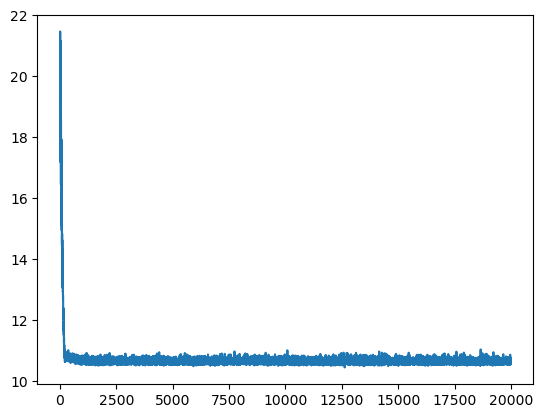

In [467]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),np.log(losses))

In [468]:
adata_tensor.shape

torch.Size([1000, 1000])

In [469]:
pyro.get_param_store().named_parameters()

dict_items([('theta_sq', tensor(-1.1141, requires_grad=True)), ('theta_lq', tensor(0., requires_grad=True)), ('a_q', tensor(2.7929, requires_grad=True)), ('ap_q', tensor(2.2016, requires_grad=True)), ('eta_0', tensor(2.8381, requires_grad=True)), ('eta_1', tensor(0.7919, requires_grad=True)), ('theta', tensor([3.4348e-02, 2.5375e-03, 2.8147e-04, 3.1031e-05, 5.3524e-07, 1.6595e+00,
        1.3287e-05, 7.5836e-02, 3.7318e-03, 3.9297e-01, 1.8563e-02, 2.6394e-01,
        3.0382e-03, 1.5226e-02, 4.6808e-02, 1.1467e-01, 5.1832e-02, 4.8317e-04,
        9.1917e-01, 2.9132e-01, 2.7148e-02, 3.4199e-04, 5.5718e-01, 1.7993e+00,
        1.1374e-03, 4.2941e-03, 8.5014e-01, 1.0796e-04, 4.5963e-03, 1.2187e+00,
        1.3548e-04, 4.6869e-02, 4.9828e-02, 9.9192e-03, 1.5020e-01, 9.8172e-04,
        3.2259e-02, 3.5630e-01, 3.5980e-05, 3.6128e-02, 5.6026e-01, 6.1759e-02,
        1.6048e-05, 2.5570e+00, 1.6475e-01, 4.4135e-02, 1.7095e+00, 1.3265e-02,
        4.0049e-01, 1.3046e-01, 1.3226e-01, 5.1296e-02, 

In [470]:
theta = dict(pyro.get_param_store().named_parameters())['theta']
beta = dict(pyro.get_param_store().named_parameters())['beta']

In [471]:
lambd = np.zeros((theta.shape[0],beta.shape[0]))
for i in range(lambd.shape[0]):
    for j in range(lambd.shape[1]):
        lambd[i][j] = theta[i] * beta[j]

In [472]:
posteriors_all = []
for k in range(1000):
    if k % 100 == 0:
        print(k)
    posterior = np.zeros(lambd.shape)
    for i in range(lambd.shape[0]):
        for j in range(lambd.shape[1]):
            posterior[i][j] = np.random.poisson(lambd[i][j])
    posteriors_all.append(posterior)

0
100
200
300
400
500
600
700
800
900


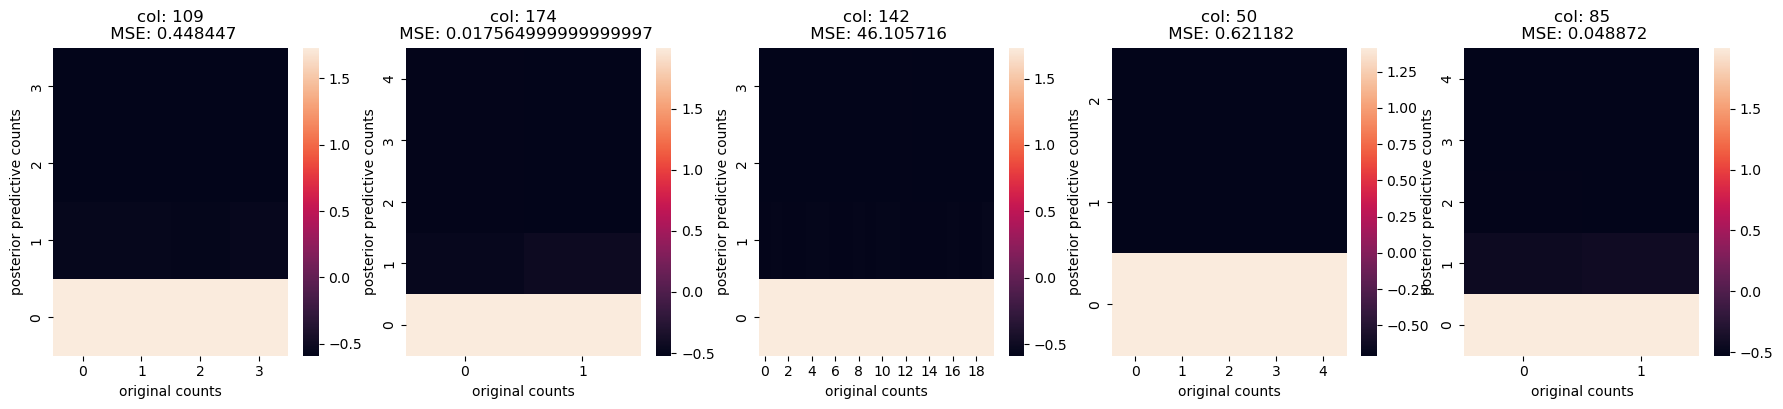

In [473]:
posteriors_all = np.asarray(posteriors_all)
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
ind = 0
rands = np.random.choice([i for i in range(200)], size=5, replace=False)
#print(rands)
for col in rands:
    combined_x = []
    combined_y = []
    heatmap = np.zeros((int(max(posteriors_all[:, :, col].flatten())) + 1,
                        int(max(adata_subsampled.layers['counts'][:, col]))
                        + 1))
    max_post = int(max(posteriors_all[:, :, col].flatten()))
    for i in range(1000):
        combined_x.append(adata_subsampled.layers['counts'][:, col])
      #  print(combined_x[0].shape)
        combined_y.append(posteriors_all[i][:, col])
        for j in range(num_cells):
            tmp_coord = int(adata_subsampled.layers['counts'][j, col])
          #  print(posteriors_all.shape)
            heatmap[max_post -
                    int(posteriors_all[i, j, col])][tmp_coord] += 1
    MSE = sklearn.metrics.mean_squared_error(combined_x, combined_y)
    hmap = pd.DataFrame(scipy.stats.zscore(heatmap))
    hmap.columns = [i for i in range(heatmap.shape[1])]
    hmap.index = np.flip([i for i in range(heatmap.shape[0])])
    g = sns.heatmap(hmap, ax=ax[ind])
    g.set_facecolor('black')
    g.set_xlabel("original counts")
    g.set_ylabel("posterior predictive counts")
    g.set_title("col: " + str(col) + "\n MSE: " + str(MSE))
    ind += 1

In [444]:
posteriors_all.shape

(1000, 800, 1000)

In [445]:
lambd.shape

(800, 1000)

In [453]:
len(combined_x[0])

1000

In [454]:
len(combined_y[0])

800